# Isolation Tree vs. K-Means Isolation Tree

### Dependencies

In [4]:
%pip install scikit-learn
%pip install matplotlib
%pip install numpy
%pip install pyod

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: C:\Users\razva\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: C:\Users\razva\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: C:\Users\razva\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: C:\Users\razva\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [1]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from pyod.utils.data import generate_data
from sklearn.cluster import KMeans

## Isolation Tree

### Isolation Tree Node

In [2]:
class IsolationTreeNode:
    def __init__(self, depth, feature_limits):
        self.depth = depth
        self.feature_limits = feature_limits

        self.idx_feature = None
        self.split_threshold = None

        self.children = []
        self.data = None


    def partition_space(self, Xs, MAX_DEPTH):
        if self.depth == MAX_DEPTH or Xs.shape[0] <= 1 or np.all(Xs == Xs[0]):
            self.data = Xs
            return

        self.idx_feature = np.random.randint(Xs.shape[1])
        self.split_threshold = np.random.uniform(
            self.feature_limits[self.idx_feature][0],
            self.feature_limits[self.idx_feature][1]
        )

        Xs_lower = Xs[Xs[:, self.idx_feature] < self.split_threshold]
        Xs_upper = Xs[Xs[:, self.idx_feature] >= self.split_threshold]

        feature_limits_lower = deepcopy(self.feature_limits)
        feature_limits_lower[self.idx_feature][1] = self.split_threshold
        feature_limits_upper = deepcopy(self.feature_limits)
        feature_limits_upper[self.idx_feature][0] = self.split_threshold

        child_lower = IsolationTreeNode(
            depth=self.depth + 1,
            feature_limits=feature_limits_lower
        )
        child_upper = IsolationTreeNode(
            depth=self.depth + 1,
            feature_limits=feature_limits_upper
        )
        
        self.children = [child_lower, child_upper]
        self.children[0].partition_space(Xs_lower, MAX_DEPTH)
        self.children[1].partition_space(Xs_upper, MAX_DEPTH)


    def get_path_length(self, X):
        if self.data is not None:
            return 0
        
        if X[self.idx_feature] < self.split_threshold:
            return 1 + self.children[0].get_path_length(X)
        else:
            return 1 + self.children[1].get_path_length(X)
    

    def plot_partition_space_2D(self):
        if self.data is not None:
            plt.scatter(self.data[:, 0], self.data[:, 1], c='lightgray', s=5)
            return

        if self.idx_feature is not None and self.split_threshold is not None:
            if self.idx_feature == 0:
                plt.plot([self.split_threshold, self.split_threshold],
                         [self.feature_limits[1][0], self.feature_limits[1][1]], c='gray')
            else:
                plt.plot([self.feature_limits[0][0], self.feature_limits[0][1]],
                         [self.split_threshold, self.split_threshold], c='gray')
                
        for child in self.children:
            child.plot_partition_space_2D()

### Isolation Tree

In [10]:
class IsolationTree:
    def __init__(self):
        self.feature_limits = None
        self.root = None

        self.expected_path_length = None
        self.contamination = None
        self.anomaly_threshold = None

        self.PADDING = 1.0
    

    def fit(self, Xs, subsample_size=256, contamination=0.1):
        self.feature_limits = []
        for i in range(Xs.shape[1]):
            self.feature_limits.append([np.min(Xs[:, i]) - self.PADDING, np.max(Xs[:, i]) + self.PADDING])

        self.root = IsolationTreeNode(
            depth=0,
            feature_limits=self.feature_limits
        )

        if subsample_size is not None and subsample_size < Xs.shape[0]:
            subsample_indices = np.random.choice(Xs.shape[0], subsample_size, replace=False)
            Xs_train = Xs[subsample_indices]
        else:
            Xs_train = Xs

        if Xs_train.shape[0] <= 1:
            self.expected_path_length = 0
        else:
            HARMONIC_NUMBER = np.log(Xs_train.shape[0] - 1) + 0.5772156649
            self.expected_path_length = 2.0 * (HARMONIC_NUMBER - (Xs_train.shape[0] - 1) / Xs_train.shape[0])

        MAX_HEIGHT = int(np.ceil(np.log2(Xs_train.shape[0])))
        self.root.partition_space(Xs_train, MAX_HEIGHT)

        self.contamination = contamination
        if self.contamination is None:
            self.anomaly_threshold = 0.5
        else:
            Xs_train_depths = []
            for i in range(Xs_train.shape[0]):
                depth = self.root.get_path_length(Xs_train[i])
                Xs_train_depths.append(depth)
            Xs_train_depths = np.array(Xs_train_depths)

            Xs_train_anomaly_scores = 2.0 ** (-Xs_train_depths / self.expected_path_length)
            self.anomaly_threshold = np.quantile(Xs_train_anomaly_scores, 1.0 - self.contamination)


    def scores(self, Xs):
        scores = []
        for i in range(Xs.shape[0]):
            depth = self.root.get_path_length(Xs[i])
            score = 2.0 ** (-depth / self.expected_path_length)
            scores.append(score)
            
        scores = np.array(scores)
        return scores
    

    def predict(self, Xs):
        scores = self.scores(Xs)
        predictions = (scores >= self.anomaly_threshold).astype(int)
        return predictions
    

    def get_path_lengths(self, Xs):
        path_lengths = []
        for i in range(Xs.shape[0]):
            path_length = self.root.get_path_length(Xs[i])
            path_lengths.append(path_length)

        path_lengths = np.array(path_lengths)
        return path_lengths


    def plot_partition_space_2D(self):
        plt.title(f'Space Partition Isolation Tree')
        plt.xlabel('X')
        plt.ylabel('Y')

        plt.plot([self.feature_limits[0][0], self.feature_limits[0][1]],
                 [self.feature_limits[1][0], self.feature_limits[1][0]], c='gray')
        plt.plot([self.feature_limits[0][0], self.feature_limits[0][1]],
                 [self.feature_limits[1][1], self.feature_limits[1][1]], c='gray')
        plt.plot([self.feature_limits[0][0], self.feature_limits[0][0]],
                 [self.feature_limits[1][0], self.feature_limits[1][1]], c='gray')
        plt.plot([self.feature_limits[0][1], self.feature_limits[0][1]],
                 [self.feature_limits[1][0], self.feature_limits[1][1]], c='gray')

        self.root.plot_partition_space_2D()
        plt.show()

### Isolation Forest

In [4]:
class IsolationForest:
    def __init__(self, ensemble_size=100):
        self.ensemble_size = ensemble_size

        self.expected_path_length = None
        self.contamination = None
        self.anomaly_threshold = None

        self.trees = []
    

    def fit(self, Xs, subsample_size=256, contamination=0.1):
        self.trees = []
        for _ in range(self.ensemble_size):
            isolation_tree = IsolationTree()
            isolation_tree.fit(Xs, subsample_size=subsample_size)
            self.trees.append(isolation_tree)

        if subsample_size is not None and subsample_size < Xs.shape[0]:
            train_size = subsample_size
        else:
            train_size = Xs.shape[0]

        if train_size <= 1:
            self.expected_path_length = 0
        else:
            HARMONIC_NUMBER = np.log(train_size - 1) + 0.5772156649
            self.expected_path_length = 2.0 * (HARMONIC_NUMBER - (train_size - 1) / train_size)

        self.contamination = contamination
        if self.contamination is None:
            self.anomaly_threshold = 0.5
        else:
            Xs_train_mean_depths = []
            for i in range(Xs.shape[0]):
                mean_depth = np.mean([tree.root.get_path_length(Xs[i]) for tree in self.trees])
                Xs_train_mean_depths.append(mean_depth)
            Xs_train_mean_depths = np.array(Xs_train_mean_depths)

            Xs_train_anomaly_scores = 2.0 ** (-Xs_train_mean_depths / self.expected_path_length)
            self.anomaly_threshold = np.quantile(Xs_train_anomaly_scores, 1.0 - self.contamination)


    def scores(self, Xs):
        scores = []
        for i in range(Xs.shape[0]):
            mean_depth = np.mean([tree.root.get_path_length(Xs[i]) for tree in self.trees])
            score = 2.0 ** (-mean_depth / self.expected_path_length)
            scores.append(score)
            
        scores = np.array(scores)
        return scores
    

    def predict(self, Xs):
        scores = self.scores(Xs)
        predictions = (scores >= self.anomaly_threshold).astype(int)
        return predictions

## K-Means Isolation Tree

### Elbow Rule

In [ ]:
def find_optimal_k(Xs):
    initial_Ks = [2, 3, 5, 7, 10, 13]
    Ks = [k for k in initial_Ks if k <= Xs.shape[0]]

    inertias = []

    for k in Ks:
        kmeans = KMeans(n_clusters=k, random_state=23)
        kmeans.fit(Xs)

        inertias.append(kmeans.inertia_)

    if len(Ks) <= 2:
        return Ks[0]

    start_point = np.array([Ks[0], inertias[0]])
    end_point = np.array([Ks[-1], inertias[-1]])
    distances = []

    for i in range(len(Ks)):
        current_point = np.array([Ks[i], inertias[i]])

        area = np.abs(np.cross(end_point - start_point, current_point - start_point))
        base_length = np.linalg.norm(end_point - start_point)

        distance = area / base_length
        distances.append(distance)

    optimal_k = Ks[np.argmax(distances)]
    return optimal_k 

In [7]:
def plot_elbow_rule(Xs):
    initial_Ks = [2, 3, 5, 7, 10, 13, 15, 17, 20, 25, 30, 40, 50, 75, 100]
    Ks = [k for k in initial_Ks if k <= Xs.shape[0]]

    inertias = []

    for k in Ks:
        kmeans = KMeans(n_clusters=k, random_state=23)
        kmeans.fit(Xs)

        inertias.append(kmeans.inertia_)

    optimal_k = find_optimal_k(Xs)

    plt.plot(Ks, inertias)
    plt.plot([Ks[0], Ks[-1]], [inertias[0], inertias[-1]])
    plt.scatter(optimal_k, inertias[Ks.index(optimal_k)])
    plt.title('Elbow Rule for Optimal K')
    plt.xlabel('Number of Clusters K')
    plt.ylabel('Inertia')
    plt.show()

C:\Users\razva\AppData\Local\Temp\ipykernel_17960\2507643261.py:23: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  area = np.abs(np.cross(end_point - start_point, current_point - start_point))


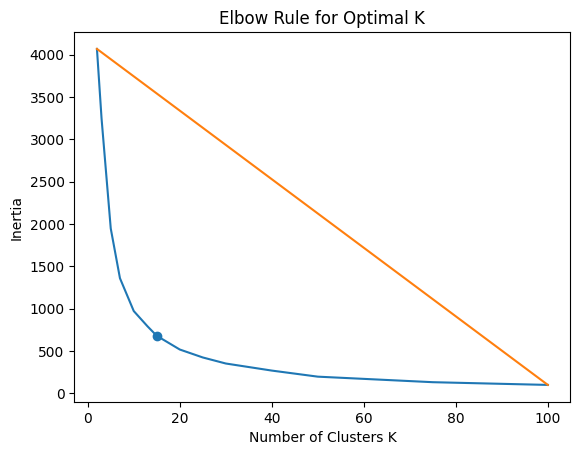

Elbow Rule Optimal K: 15


C:\Users\razva\AppData\Local\Temp\ipykernel_17960\2507643261.py:23: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  area = np.abs(np.cross(end_point - start_point, current_point - start_point))


In [8]:
Xs_train, Xs_test, Ys_train, Ys_test = generate_data(n_train=3000, n_test=100, n_features=2, contamination=0.1, random_state=23)

plot_elbow_rule(Xs_train)

print(f'Elbow Rule Optimal K: {find_optimal_k(Xs_train)}')

### K-Means Isolation Tree Node

In [23]:
class KMeansIsolationTreeNode:
    def __init__(self, depth, feature_limits):
        self.depth = depth
        self.feature_limits = feature_limits

        self.idx_feature = None
        self.split_thresholds = []
        self.cluster_centers = []
        self.cluster_radii = []

        self.children = []
        self.data = None


    def partition_space(self, Xs, MAX_DEPTH):
        if self.depth == MAX_DEPTH or Xs.shape[0] <= 1 or np.all(Xs == Xs[0]):
            self.data = Xs
            return

        self.idx_feature = np.random.randint(Xs.shape[1])
        Xs_projected = Xs[:, self.idx_feature]

        optimal_k = find_optimal_k(Xs_projected.reshape(-1, 1))
        kmeans = KMeans(n_clusters=optimal_k, random_state=23)
        kmeans.fit(Xs_projected.reshape(-1, 1))

        self.cluster_centers = sorted(kmeans.cluster_centers_.flatten().tolist())
        self.split_thresholds = []
        for idx in range(1, len(self.cluster_centers)):
            split_threshold = (self.cluster_centers[idx - 1] + self.cluster_centers[idx]) / 2.0
            self.split_thresholds.append(split_threshold)
        self.cluster_radii = [0.0 for _ in range(len(self.cluster_centers))]
        for X_projected in Xs_projected:
            cluster_distances = [np.abs(X_projected - cluster_center) for cluster_center in self.cluster_centers]
            closest_cluster_idx = np.argmin(cluster_distances)
            if cluster_distances[closest_cluster_idx] > self.cluster_radii[closest_cluster_idx]:
                self.cluster_radii[closest_cluster_idx] = cluster_distances[closest_cluster_idx]

        self.children = []
        for idx in range(len(self.split_thresholds)):
            if idx == 0:
                threshold_lower = self.feature_limits[self.idx_feature][0]
            else:
                threshold_lower = self.split_thresholds[idx - 1]
            threshold_upper = self.split_thresholds[idx]

            Xs_between = Xs[
                (threshold_lower <= Xs[:, self.idx_feature]) &
                (Xs[:, self.idx_feature] < threshold_upper)
            ]

            feature_limits_between = deepcopy(self.feature_limits)
            feature_limits_between[self.idx_feature][0] = threshold_lower
            feature_limits_between[self.idx_feature][1] = threshold_upper

            child = KMeansIsolationTreeNode(
                depth=self.depth + 1,
                feature_limits=feature_limits_between
            )
            self.children.append(child)
            self.children[-1].partition_space(Xs_between, MAX_DEPTH)

        threshold_lower = self.split_thresholds[-1]
        threshold_upper = self.feature_limits[self.idx_feature][1]

        Xs_between = Xs[
            (threshold_lower <= Xs[:, self.idx_feature]) &
            (Xs[:, self.idx_feature] <= threshold_upper)
        ]

        feature_limits_between = deepcopy(self.feature_limits)
        feature_limits_between[self.idx_feature][0] = threshold_lower
        feature_limits_between[self.idx_feature][1] = threshold_upper

        child = KMeansIsolationTreeNode(
            depth=self.depth + 1,
            feature_limits=feature_limits_between
        )
        self.children.append(child)
        self.children[-1].partition_space(Xs_between, MAX_DEPTH)


    def get_path_length(self, X):
        if self.data is not None:
            return 0
        
        for idx in range(len(self.split_thresholds)):
            if X[self.idx_feature] < self.split_thresholds[idx]:
                return 1 + self.children[idx].get_path_length(X)
        return 1 + self.children[-1].get_path_length(X)
    

    def get_normality_score(self, X):
        if self.data is not None:
            return 0.0

        X_projected = X[self.idx_feature]

        cluster_distances = [np.abs(X_projected - cluster_center) for cluster_center in self.cluster_centers]
        closest_cluster_idx = np.argmin(cluster_distances)
        cluster_radius = self.cluster_radii[closest_cluster_idx]

        if cluster_radius == 0.0:
            normality_score = 1.0
        else:
            normality_score = 1.0 - (cluster_distances[closest_cluster_idx] / cluster_radius)
        
        for idx in range(len(self.split_thresholds)):
            if X_projected < self.split_thresholds[idx]:
                return normality_score + self.children[idx].get_normality_score(X)
        return normality_score + self.children[-1].get_normality_score(X)
    

    def plot_partition_space_2D(self):
        if self.data is not None:
            plt.scatter(self.data[:, 0], self.data[:, 1], c='lightgray', s=5)
            return

        if self.idx_feature is not None:
            if self.idx_feature == 0:
                for split_threshold in self.split_thresholds:
                    plt.plot([split_threshold, split_threshold],
                            [self.feature_limits[1][0], self.feature_limits[1][1]], c='gray')
            else:
                for split_threshold in self.split_thresholds:
                    plt.plot([self.feature_limits[0][0], self.feature_limits[0][1]],
                            [split_threshold, split_threshold], c='gray')
                
        for child in self.children:
            child.plot_partition_space_2D()

### K-Means Isolation Tree

In [24]:
class KMeansIsolationTree:
    def __init__(self):
        self.feature_limits = None
        self.root = None

        self.contamination = None
        self.anomaly_threshold = None

        self.PADDING = 1.0
    

    def fit(self, Xs, subsample_size=256, contamination=0.1):
        self.feature_limits = []
        for i in range(Xs.shape[1]):
            self.feature_limits.append([np.min(Xs[:, i]) - self.PADDING, np.max(Xs[:, i]) + self.PADDING])

        self.root = KMeansIsolationTreeNode(
            depth=0,
            feature_limits=self.feature_limits
        )

        if subsample_size is not None and subsample_size < Xs.shape[0]:
            subsample_indices = np.random.choice(Xs.shape[0], subsample_size, replace=False)
            Xs_train = Xs[subsample_indices]
        else:
            Xs_train = Xs

        MAX_HEIGHT = int(np.ceil(np.log2(Xs_train.shape[0])))
        self.root.partition_space(Xs_train, MAX_HEIGHT)

        self.contamination = contamination
        if self.contamination is None:
            self.anomaly_threshold = 0.5
        else:
            Xs_train_normality_scores = []
            for i in range(Xs_train.shape[0]):
                normality_score = self.root.get_normality_score(Xs_train[i])
                Xs_train_normality_scores.append(normality_score)
            Xs_train_normality_scores = np.array(Xs_train_normality_scores)

            Xs_train_anomaly_scores = 1.0 - Xs_train_normality_scores
            self.anomaly_threshold = np.quantile(Xs_train_anomaly_scores, 1.0 - self.contamination)


    def normality_scores(self, Xs):
        normality_scores = []
        for i in range(Xs.shape[0]):
            normality_score = self.root.get_normality_score(Xs[i])
            normality_scores.append(normality_score)
            
        normality_scores = np.array(normality_scores)
        return normality_scores
    

    def anomaly_scores(self, Xs):
        normality_scores = self.normality_scores(Xs)
        anomaly_scores = 1.0 - normality_scores
        return anomaly_scores
    

    def predict(self, Xs):
        anomaly_scores = self.anomaly_scores(Xs)
        predictions = (anomaly_scores >= self.anomaly_threshold).astype(int)
        return predictions
    

    def get_path_lengths(self, Xs):
        path_lengths = []
        for i in range(Xs.shape[0]):
            path_length = self.root.get_path_length(Xs[i])
            path_lengths.append(path_length)

        path_lengths = np.array(path_lengths)
        return path_lengths


    def plot_partition_space_2D(self):
        plt.title(f'Space Partition KMeans Isolation Tree')
        plt.xlabel('X')
        plt.ylabel('Y')

        plt.plot([self.feature_limits[0][0], self.feature_limits[0][1]],
                 [self.feature_limits[1][0], self.feature_limits[1][0]], c='gray')
        plt.plot([self.feature_limits[0][0], self.feature_limits[0][1]],
                 [self.feature_limits[1][1], self.feature_limits[1][1]], c='gray')
        plt.plot([self.feature_limits[0][0], self.feature_limits[0][0]],
                 [self.feature_limits[1][0], self.feature_limits[1][1]], c='gray')
        plt.plot([self.feature_limits[0][1], self.feature_limits[0][1]],
                 [self.feature_limits[1][0], self.feature_limits[1][1]], c='gray')

        self.root.plot_partition_space_2D()
        plt.show()        

### K-Means Isolation Forest

In [25]:
class KMeansIsolationForest:
    def __init__(self, ensemble_size=100):
        self.ensemble_size = ensemble_size

        self.contamination = None
        self.anomaly_threshold = None

        self.trees = []
    

    def fit(self, Xs, subsample_size=256, contamination=0.1):
        self.trees = []
        for _ in range(self.ensemble_size):
            kmeans_isolation_tree = KMeansIsolationTree()
            kmeans_isolation_tree.fit(Xs, subsample_size=subsample_size)
            self.trees.append(kmeans_isolation_tree)

        if subsample_size is not None and subsample_size < Xs.shape[0]:
            train_size = subsample_size
        else:
            train_size = Xs.shape[0]

        self.contamination = contamination
        if self.contamination is None:
            self.anomaly_threshold = 0.5
        else:
            Xs_train_mean_normality_scores = []
            for i in range(Xs.shape[0]):
                mean_normality_score = np.mean([tree.root.get_normality_score(Xs[i]) for tree in self.trees])
                Xs_train_mean_normality_scores.append(mean_normality_score)
            Xs_train_mean_normality_scores = np.array(Xs_train_mean_normality_scores)

            Xs_train_anomaly_scores = 1.0 - Xs_train_mean_normality_scores
            self.anomaly_threshold = np.quantile(Xs_train_anomaly_scores, 1.0 - self.contamination)


    def anomaly_scores(self, Xs):
        anomaly_scores = []
        for i in range(Xs.shape[0]):
            mean_normality_score = np.mean([tree.root.get_normality_score(Xs[i]) for tree in self.trees])
            anomaly_score = 1.0 - mean_normality_score
            anomaly_scores.append(anomaly_score)
            
        anomaly_scores = np.array(anomaly_scores)
        return anomaly_scores
    

    def predict(self, Xs):
        anomaly_scores = self.anomaly_scores(Xs)
        predictions = (anomaly_scores >= self.anomaly_threshold).astype(int)
        return predictions

### Small Tests

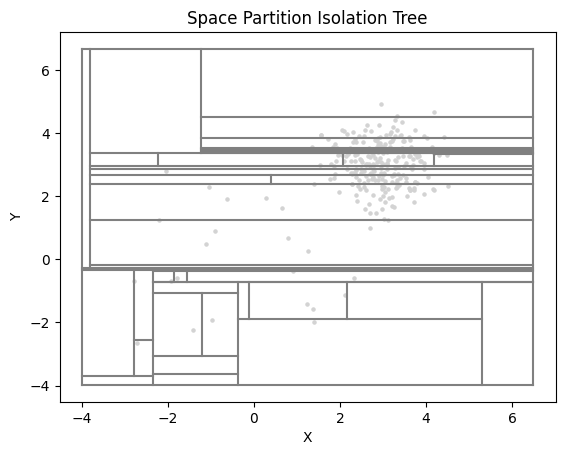

Accuracy:  0.1
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0.58200918 0.58200918 0.58200918 0.58200918 0.58200918 0.58200918
 0.58200918 0.58200918 0.58200918 0.58200918 0.58200918 0.58200918
 0.58200918 0.58200918 0.58200918 0.58200918 0.58200918 0.58200918
 0.58200918 0.58200918 0.58200918 0.58200918 0.58200918 0.58200918
 0.58200918 0.58200918 0.58200918 0.58200918 0.58200918 0.58200918
 0.58200918 0.58200918 0.58200918 0.58200918 0.58200918 0.58200918
 0.58200918 0.58200918 0.58200918 0.58200918 0.58200918 0.58200918
 0.58200918 0.58200918 0.58200918 0.58200918 0.58200918 0.58200918
 0.58200918 0.58200918 0.58200918 0.58200918 0.58200918 0.58200918
 0.58200918 0.58200918 0.58200918 0.58200918 0.58200918 0.58200918
 0.58200918 0.58200918 0.58200918 0.58200918 0.58200918 0.58200918
 0.58200918 0.58200918 0.58200918 0.58200918

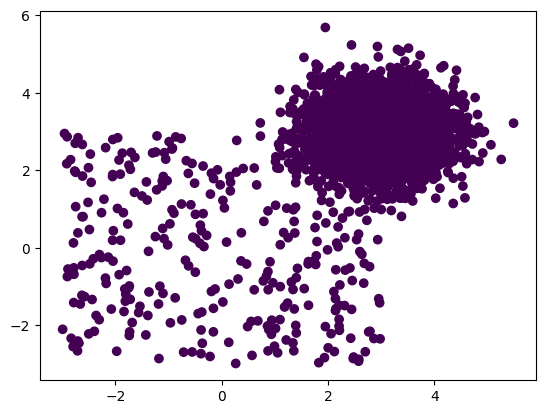

In [26]:
Xs_train, Xs_test, Ys_train, Ys_test = generate_data(n_train=3000, n_test=100, n_features=2, contamination=0.1, random_state=23)

isolation_tree = IsolationTree()
isolation_tree.fit(Xs_train, subsample_size=256, contamination=0.1)
isolation_tree.plot_partition_space_2D()

predictions = isolation_tree.predict(Xs_test)
print('Accuracy: ', np.mean(predictions == Ys_test))

print(predictions)

plt.scatter(Xs_test[:, 0], Xs_test[:, 1], c=predictions)
print(isolation_tree.scores(Xs_test))

print(isolation_tree.anomaly_threshold)

train_pred = isolation_tree.predict(Xs_train)
plt.scatter(Xs_train[:, 0], Xs_train[:, 1], c=train_pred)
train_accuracy = np.mean(train_pred == Ys_train)
print('Train Accuracy: ', train_accuracy)

Isolation Forest Accuracy:  0.95


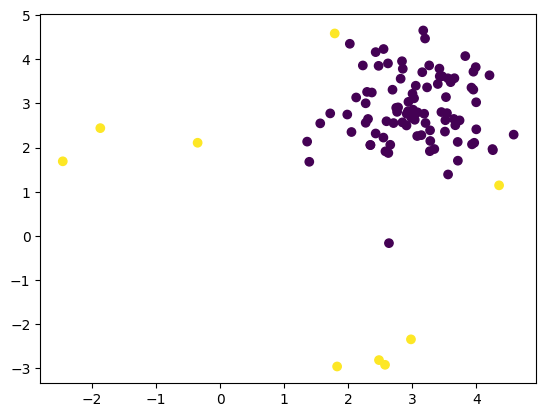

Isolation Forest Train Accuracy:  0.966


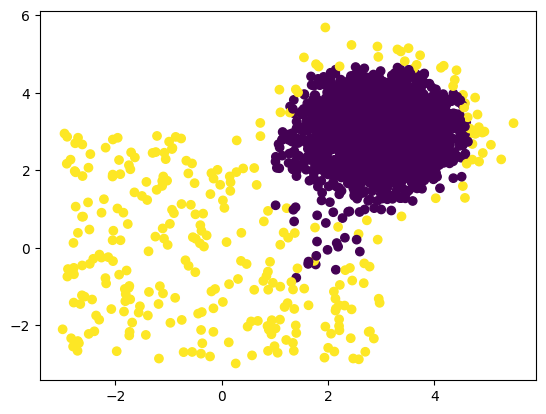

In [27]:
isolation_forest = IsolationForest(ensemble_size=100)
isolation_forest.fit(Xs_train, subsample_size=256, contamination=0.1)

isolation_forest_predictions = isolation_forest.predict(Xs_test)
print('Isolation Forest Accuracy: ', np.mean(isolation_forest_predictions == Ys_test))

plt.scatter(Xs_test[:, 0], Xs_test[:, 1], c=isolation_forest_predictions)
plt.show()

isolation_forest_predictions = isolation_forest.predict(Xs_train)
print('Isolation Forest Train Accuracy: ', np.mean(isolation_forest_predictions == Ys_train))

plt.scatter(Xs_train[:, 0], Xs_train[:, 1], c=isolation_forest_predictions)
plt.show()

C:\Users\razva\AppData\Local\Temp\ipykernel_17960\2507643261.py:23: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  area = np.abs(np.cross(end_point - start_point, current_point - start_point))
C:\Users\razva\AppData\Local\Temp\ipykernel_17960\2507643261.py:23: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  area = np.abs(np.cross(end_point - start_point, current_point - start_point))
C:\Users\razva\AppData\Local\Temp\ipykernel_17960\2507643261.py:23: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  area = np.abs(np.cross(end_point - start_point, current_point - start_point))
C:\Users\razva\AppData\Local\Temp\ipykernel_17960\2507643261.py:23: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use

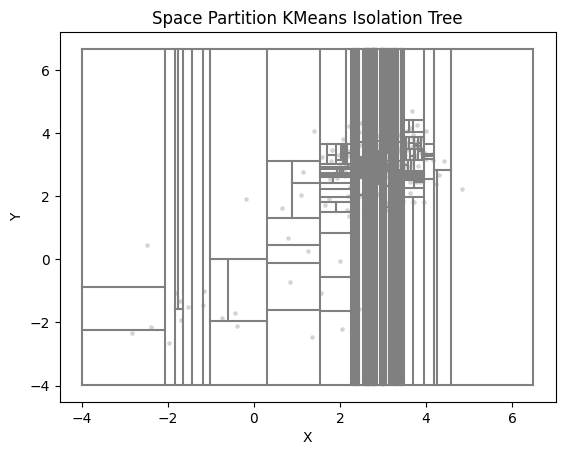

KMeans Isolation Tree Accuracy:  0.45


In [28]:
kmeans_isolation_tree = KMeansIsolationTree()
kmeans_isolation_tree.fit(Xs_train, subsample_size=256, contamination=0.1)
kmeans_isolation_tree.plot_partition_space_2D()

predictions = kmeans_isolation_tree.predict(Xs_test)
print('KMeans Isolation Tree Accuracy: ', np.mean(predictions == Ys_test))

C:\Users\razva\AppData\Local\Temp\ipykernel_17960\2507643261.py:23: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  area = np.abs(np.cross(end_point - start_point, current_point - start_point))
C:\Users\razva\AppData\Local\Temp\ipykernel_17960\2507643261.py:23: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  area = np.abs(np.cross(end_point - start_point, current_point - start_point))
C:\Users\razva\AppData\Local\Temp\ipykernel_17960\2507643261.py:23: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  area = np.abs(np.cross(end_point - start_point, current_point - start_point))
C:\Users\razva\AppData\Local\Temp\ipykernel_17960\2507643261.py:23: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use

KMeans Isolation Forest Accuracy:  0.94


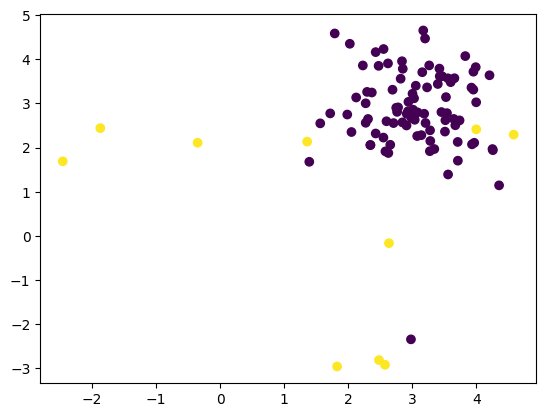

KMeans Isolation Forest Train Accuracy:  0.9753333333333334


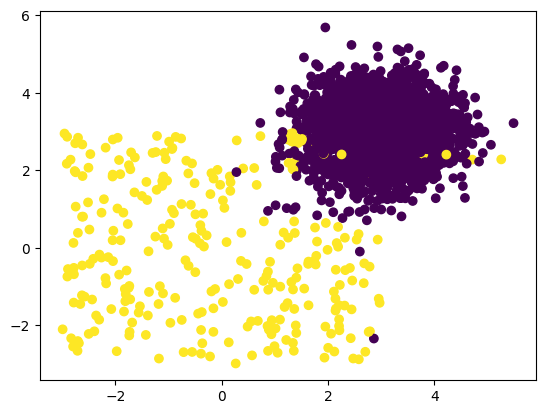

In [29]:
kmeans_isolation_forest = KMeansIsolationForest(ensemble_size=100)
kmeans_isolation_forest.fit(Xs_train, subsample_size=256, contamination=0.1)

kmeans_isolation_forest_predictions = kmeans_isolation_forest.predict(Xs_test)
print('KMeans Isolation Forest Accuracy: ', np.mean(kmeans_isolation_forest_predictions == Ys_test))

plt.scatter(Xs_test[:, 0], Xs_test[:, 1], c=kmeans_isolation_forest_predictions)
plt.show()

kmeans_isolation_forest_predictions = kmeans_isolation_forest.predict(Xs_train)
print('KMeans Isolation Forest Train Accuracy: ', np.mean(kmeans_isolation_forest_predictions == Ys_train))
plt.scatter(Xs_train[:, 0], Xs_train[:, 1], c=kmeans_isolation_forest_predictions)
plt.show()

### Robustness Tests

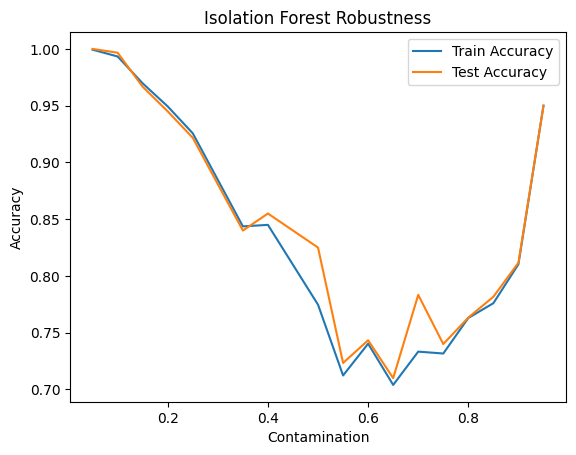

In [31]:
contaminations = [0.05, 0.1, 0.15, 0.2, 0.25, 0.35, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
train_accuracies = []
test_accuracies = []

for contamination in contaminations:
    Xs_train, Xs_test, Ys_train, Ys_test = generate_data(n_train=3000, n_test=600, n_features=10, contamination=contamination, random_state=23)

    isolation_forest = IsolationForest(ensemble_size=100)
    isolation_forest.fit(Xs_train, subsample_size=256, contamination=contamination)

    train_predictions = isolation_forest.predict(Xs_train)
    test_predictions = isolation_forest.predict(Xs_test)

    train_accuracy = np.mean(train_predictions == Ys_train)
    test_accuracy = np.mean(test_predictions == Ys_test)

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

plt.plot(contaminations, train_accuracies, label='Train Accuracy')
plt.plot(contaminations, test_accuracies, label='Test Accuracy')
plt.xlabel('Contamination')
plt.ylabel('Accuracy')
plt.title('Isolation Forest Robustness')
plt.legend()
plt.show()

In [33]:
import warnings
warnings.filterwarnings('ignore')

In [34]:
contaminations = [0.05, 0.1, 0.15, 0.2, 0.25, 0.35, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
train_accuracies = []
test_accuracies = []

for contamination in contaminations:
    Xs_train, Xs_test, Ys_train, Ys_test = generate_data(n_train=3000, n_test=600, n_features=10, contamination=contamination, random_state=23)

    kmeans_isolation_forest = KMeansIsolationForest(ensemble_size=100)
    kmeans_isolation_forest.fit(Xs_train, subsample_size=256, contamination=contamination)

    train_predictions = kmeans_isolation_forest.predict(Xs_train)
    test_predictions = kmeans_isolation_forest.predict(Xs_test)

    train_accuracy = np.mean(train_predictions == Ys_train)
    test_accuracy = np.mean(test_predictions == Ys_test)

    print(f'Train Accuracy with contamination={contamination}: {train_accuracy}')
    print(f'Test Accuracy with contamination={contamination}: {test_accuracy}')

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

plt.plot(contaminations, train_accuracies, label='Train Accuracy')
plt.plot(contaminations, test_accuracies, label='Test Accuracy')
plt.xlabel('Contamination')
plt.ylabel('Accuracy')
plt.title('KMeans Isolation Forest Robustness')
plt.legend()
plt.show()

Train Accuracy with contamination=0.05: 0.9973333333333333
Test Accuracy with contamination=0.05: 0.9966666666666667
Train Accuracy with contamination=0.1: 0.994
Test Accuracy with contamination=0.1: 0.9966666666666667
Train Accuracy with contamination=0.15: 0.99
Test Accuracy with contamination=0.15: 0.9966666666666667


KeyboardInterrupt: 